<!-- # Make Dataset

- sample positve class
- sample negative class
- refine negative -->

In [28]:
# Autorelaod
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import igraph as ig
import leidenalg
from scipy.special import softmax
import re
from statsmodels.stats.multitest import multipletests

os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.dataset_functions as dataf

config_file="/home/gdallagl/myworkdir/ESMSec/config/config.yaml"
config = mf.load_config(config_file)

mf.set_all_seeds(config["random_seed"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
Seeds set successfully to 42 for random, numpy, and PyTorch (if used).


<!-- # Load definitive positive genes -->

In [29]:
#positive_genes_path = config["data_paths"]["final_positive_genes"]

positive_genes_path = "/home/gdallagl/myworkdir/ESMSec/data/cell_location/nucleus_01_positive_proteins.csv"
positive_genes_df = pd.read_csv(positive_genes_path)
NAME_DATASET = positive_genes_path.split("/")[-1].split("_")[0]
print(NAME_DATASET)

display(positive_genes_df)
positive_genes = set(positive_genes_df[positive_genes_df.definitive_positive == True].gene)
ambiguos_genes = set(positive_genes_df[positive_genes_df.definitive_positive == False].gene)
print("Number positive genes", len(positive_genes))
print("Number ambiguos genes", len(ambiguos_genes))

nucleus


,protein,Length,locations,gene,n_locations,sequence,geneset_count,definitive_positive
0,A0A0C5B5G6,16,"{'mitochondrion', 'extracellular space', 'nucl...",MT-RNR1,3,MRWQEMGYIFYPRKLR,1,1
1,A0AV96,593,"{'nucleus', 'cytoplasm', 'apolipoprotein b mrn...",RBM47,3,MTAEDSTAAMSSDSAAGSSAKVPEGVAGAPNEAALLALMERTGYSM...,1,1
2,A0AVT1,1052,"{'cytosol', 'cytoplasm', 'nucleus'}",UBA6,3,MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...,1,1
3,A0JLT2,244,"{'nucleoplasm', 'nucleus', 'core mediator comp...",MED19,4,MENFTALFGAQADPPPPPTALGFGPGKPPPPPPPPAGGGPGTAPPP...,1,1
4,A1A519,330,{'nucleus'},FAM170A,1,MKRRQKRKHLENEESQETAEKGGGMSKSQEDALQPGSTRVAKGWSQ...,1,1
...,...,...,...,...,...,...,...,...
5679,Q9NUC0,356,{'nucleus'},SERTAD4,1,MTLVLSMNRFCEPIVSEGAAEIAGYQTLWEADSYGGPSPPGPAQAP...,1,1
5680,Q9NWW7,574,"{'nucleoplasm', 'nucleus'}",C2orf42,2,MEPNSLRTKVPAFLSDLGKATLRGIRKCPRCGTYNGTRGLSCKNKT...,1,1
5681,Q9UHQ7,104,{'nucleus'},TCEAL9,1,MKSCQKMEGKPENESEPKHEEEPKPEEKPEEEEKLEEEAKAKGTFR...,1,1
5682,Q9Y5V0,76,"{'cytoplasm', 'nucleus'}",ZNF706,2,MARGQQKIQSQQKNAKKQAGQKKKQGHDQKAAAKAALIYTCTVCRT...,1,1


Number positive genes 5678
Number ambiguos genes 0


In [30]:
# Create mapping positive_gene --> number genesets

# make postive gene-freq mapping
    # Filter ONLY positive genes
tmp = positive_genes_df[positive_genes_df["definitive_positive"] == True]

# Create a mapping: gene -> frequency
positive_gene_freq_map = dict(zip(tmp["gene"], tmp["geneset_count"]))
positive_gene_freq_map

{'MT-RNR1': 1,
 'RBM47': 1,
 'UBA6': 1,
 'MED19': 1,
 'FAM170A': 1,
 'ODAM': 1,
 'UBE2QL1': 1,
 'SYCE3': 1,
 'FSD2': 1,
 'CIBAR1': 1,
 'MACROD2': 1,
 'ZC3H12D': 1,
 'HFM1': 1,
 'TARS3': 1,
 'MEIOC': 1,
 'PRSS37': 1,
 'MBLAC1': 1,
 'PSMB11': 1,
 'CNOT1': 1,
 'NKX2-6': 1,
 'FAM83G': 1,
 'RBMY1B': 1,
 'TMEM8B': 1,
 'OOEP': 1,
 'MSGN1': 1,
 'WTIP': 1,
 'NKX6-3': 1,
 'ARID3C': 1,
 'USP27X': 1,
 'SRRM4': 1,
 'SOBP': 1,
 'POU2AF3': 1,
 'ZNF785': 1,
 'CENPX': 1,
 'FOXI3': 1,
 'NOTO': 1,
 'SMTNL1': 1,
 'VGLL3': 1,
 'LEUTX': 1,
 'KPNA7': 1,
 'AHRR': 1,
 'ZBTB42': 1,
 'KDM4E': 1,
 'PATL2': 1,
 'MCRIP1': 1,
 'MCIDAS': 1,
 'SUMO1P1': 1,
 'TMEM250': 1,
 'SGK1': 1,
 'DDX39A': 1,
 'EYA2': 1,
 'LGALS9': 1,
 'ARVCF': 1,
 'SULT2B1': 1,
 'APBB1': 1,
 'HAS3': 1,
 'PSMD11': 1,
 'PSMD9': 1,
 'MEN1': 1,
 'CBX4': 1,
 'GET1': 1,
 'SUPT5H': 1,
 'TAF4': 1,
 'DFFA': 1,
 'RFXAP': 1,
 'HIP1': 1,
 'CLIC1': 1,
 'WWP2': 1,
 'CDC7': 1,
 'ETV2': 1,
 'BMAL1': 1,
 'FOXE1': 1,
 'WASL': 1,
 'PDE2A': 1,
 'FOXN3': 1,
 'IPO5': 

<!-- # Define set of allowed proteins for the analyss

Focus only on:
- human
- reviwed
- no isoforms -->

In [31]:
proteome_uniprot = pd.read_csv(config["data_paths"]["human_proteome_uniprot"], sep="\t")

# ONLY Human 
    # csv file alredy fitered by species

# ONLY swissprot
if config["dataset_creation"]["use_only_reviewed_proteins"]:
    proteome_uniprot_reviewed = proteome_uniprot[proteome_uniprot.Reviewed == "reviewed"].copy()
    print("reviewed shape: ", proteome_uniprot_reviewed.shape)

# No isofrom, use canonical protein
proteome_uniprot_reviewed['IsIsoform'] = proteome_uniprot_reviewed['Entry'].str.contains(r'-\d+$')
n_isoforms = proteome_uniprot_reviewed['IsIsoform'].sum()
n_total = len(proteome_uniprot_reviewed)
print(f"Isoforms: {n_isoforms} / {n_total} ({n_isoforms/n_total:.2%})")

# Define proteins to use in the follwing analasys
allowed_proteins = set(proteome_uniprot_reviewed.Entry)
print("Number allowed proteins: ", len(allowed_proteins))
print(*list(allowed_proteins)[:10], "...")

reviewed shape:  (20405, 8)
Isoforms: 0 / 20405 (0.00%)
Number allowed proteins:  20405
P62910 Q8NCF5 Q9Y2P4 Q4V348 Q6ZU15 Q9C0H9 Q8NBN7 P20839 Q9Y281 A6NDE8 ...


In [ ]:
# ATTENTION: same protein can have mutliple genes
print("Gens mapping to Q9P1J3 -->", proteome_uniprot[proteome_uniprot["Entry"] == "Q9P1J3"]["Gene Names"].values)

# ATTENTION: soem proteins can have Nan geens
display(proteome_uniprot[proteome_uniprot["Entry"] == "Q9N2K0"])

# ATTNETION: are there ducplatd proteins
print("number duplicated proteins:", proteome_uniprot_reviewed.Entry.duplicated().sum())


<!-- # Create Protein -  Gene - Uniref50 Mapping -->

In [7]:
# # Read uniport ID mapping
# uniprot_id_mapping_df = pd.read_csv(config["data_paths"]["uniprot_mapping_id"], sep='\t', header=None, names=['UniProtKB_Accession', 'ID_Type', 'External_ID'])
# #print(uniprot_id_mapping_df.ID_Type.unique())
# uniprot_id_mapping_df.head(2)

,UniProtKB_Accession,ID_Type,External_ID
0,P31946,UniProtKB-ID,1433B_HUMAN
1,P31946,Gene_Name,YWHAB


In [8]:
# # select protein and gene IDs
# protein2uniref = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "UniRef50"].copy()
# gene2protein = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "Gene_Name"].copy()

# # filter only allowed proteins
# protein2uniref = protein2uniref[protein2uniref.UniProtKB_Accession.isin(allowed_proteins)]
# gene2protein = gene2protein[gene2protein.UniProtKB_Accession.isin(allowed_proteins)]

# # raname
# protein2uniref = (
#     protein2uniref
#     .rename(columns={"UniProtKB_Accession": "protein", "External_ID": "UniRef50_Cluster"})
#     .drop(columns=["ID_Type"])
# )
# gene2protein = (
#     gene2protein
#     .rename(columns={"UniProtKB_Accession": "protein", "External_ID": "gene"})
#     .drop(columns=["ID_Type"])
# )
# display(protein2uniref)
# display(gene2protein)

,protein,UniRef50_Cluster
13,P31946,UniRef50_P31946
131,P62258,UniRef50_P62258
273,Q04917,UniRef50_Q04917
377,P61981,UniRef50_P61981
541,P31947,UniRef50_P31947
...,...,...
1868137,Q6WRX3,UniRef50_Q6WRX3
1868192,Q9C0D3,UniRef50_Q9C0D3
1868268,Q15942,UniRef50_Q15942
1868355,O43149,UniRef50_O43149


,protein,gene
1,P31946,YWHAB
120,P62258,YWHAE
251,Q04917,YWHAH
342,P61981,YWHAG
470,P31947,SFN
...,...,...
1868129,Q6WRX3,ZYG11A
1868183,Q9C0D3,ZYG11B
1868246,Q15942,ZYX
1868344,O43149,ZZEF1


In [9]:
# # Create gene-protein mapping

# # Add gene name to protein
# uniref_df = pd.merge(how="inner", left=gene2protein, right=protein2uniref, on="protein")

# # ATTENTION
#     # protein --> mapped to multiple genes 
#         # (ex. special gene mutation, but same protein name)
#     # gene --> mapped to multiple protein
#         # (ex. isofoms) --> took care before (allowed_gene filtering)
#         # (ex. differt proteins)
# print("number duplciated proteins: ", uniref_df.protein.duplicated().sum()) # no protesin mapped to multiple genes
# print("number duplciated genes: ", uniref_df.gene.duplicated().sum())

# duplicated_proteins = uniref_df[uniref_df["protein"].duplicated(keep=False)]
# duplicated_genes = uniref_df[uniref_df["gene"].duplicated(keep=False)]

# display(duplicated_genes)
# display(duplicated_proteins)

number duplciated proteins:  127
number duplciated genes:  83


,protein,gene,UniRef50_Cluster
558,O43687,AKAP7,UniRef50_O43687
559,Q9P0M2,AKAP7,UniRef50_Q6JP77
611,P84996,GNAS,UniRef50_Q6R0H6
896,C0HMD6,PIDD1,UniRef50_C0HMD6
932,F7VJQ1,PRNP,UniRef50_F7VJQ1
...,...,...,...
19243,P63131,ERVK-7,UniRef50_Q9Y6I0
19244,P63122,ERVK-8,UniRef50_P10265
19245,P63127,ERVK-9,UniRef50_P63128
19932,Q70YC5,ZNF365,UniRef50_Q70YC5


,protein,gene,UniRef50_Cluster
1044,Q8IVW1,ARL17A,UniRef50_Q8IVW1
1045,Q8IVW1,ARL17B,UniRef50_Q8IVW1
1676,Q9H3K6,BOLA2,UniRef50_Q9H3K6
1677,Q9H3K6,BOLA2B,UniRef50_Q9H3K6
2284,Q8NHW4,CCL4L1,UniRef50_P10147
...,...,...,...
19153,O14599,BPY2,UniRef50_O14599
19154,O14599,BPY2B,UniRef50_O14599
19155,O14599,BPY2C,UniRef50_O14599
19467,Q9HD64,XAGE1A,UniRef50_Q9HD64


In [ ]:
# # REMOVE PORTEIN DUPLICATES

# # Subset protein with mutliple gene to have only one gene
#     # take it randomly
#     # BUT sample before a gene from "postiev_gene" if rpesent

# # add a helper column to mark whether the gene is "positive"
# uniref_df["is_positive"] = uniref_df["gene"].isin(positive_genes)

# # sort so that positive ones come first for each protein
# uniref_df = uniref_df.sort_values(["protein", "is_positive"], ascending=[True, False])

# # drop duplicates, keeping the first (which will be the positive one if it exists)
#     # ATTENTION: if there are multiple postive genes, you will lose some !!!
# uniref_df = uniref_df.drop_duplicates(subset="protein", keep="first")

# # drop the helper column if no longer needed
# uniref_df = uniref_df.drop(columns=["is_positive"])

In [ ]:
# # REMOVE GENES DUPLICATED

# # Subset genes with mutliple protein to have only one protein
#     # take it randomly
#     # BUT sample before a gene from "postiev_gene" if rpesent
# uniref_df["is_positive"] = uniref_df["gene"].isin(positive_genes)
# uniref_df = uniref_df.sort_values(["gene", "is_positive"], ascending=[True, False])
# uniref_df = uniref_df.drop_duplicates(subset="gene", keep="first")
# uniref_df = uniref_df.drop(columns=["is_positive"])

In [13]:
# # final check
# print("number duplciated proteins: ", uniref_df.protein.duplicated().sum()) # no protesin mapped to multiple genes
# print("number duplciated genes: ", uniref_df.gene.duplicated().sum())
# uniref_df

number duplciated proteins:  0
number duplciated genes:  0


,protein,gene,UniRef50_Cluster
72,P04217,A1BG,UniRef50_P04217
73,Q9NQ94,A1CF,UniRef50_Q9NQ94
83,P01023,A2M,UniRef50_P01023
84,A8K2U0,A2ML1,UniRef50_A8K2U0
86,U3KPV4,A3GALT2,UniRef50_U3KPV4
...,...,...,...
20389,Q6WRX3,ZYG11A,UniRef50_Q6WRX3
20390,Q9C0D3,ZYG11B,UniRef50_Q9C0D3
20391,Q15942,ZYX,UniRef50_Q15942
20392,O43149,ZZEF1,UniRef50_O43149


<!-- # Create Uniref50 Clusters -->

,UniRef50_Cluster,protein,gene,n_proteins,n_genes
11076,UniRef50_Q86YD7,"[Q86YD7, A6NDY2, A0A8V8TNH8, A8MX19, P0C7W8, P...","[FAM90A1, FAM90A10, FAM90A11, FAM90A12, FAM90A...",22,22
9864,UniRef50_Q6R6M4,"[Q7RTZ2, C9JJH3, C9JVI0, C9JPN9, C9JLJ4, C9J2P...","[USP17L1, USP17L10, USP17L11, USP17L12, USP17L...",19,19
7023,UniRef50_Q13066,"[P0DTW1, A6NGK3, A1L429, P0CL80, P0CL81, A6NDE...","[GAGE1, GAGE10, GAGE12B, GAGE12F, GAGE12G, GAG...",17,17
18731,UniRef50_Q9Y5E9,"[Q9UN67, Q9Y5F2, Q9Y5F1, Q9Y5F0, Q9Y5E9, Q9Y5E...","[PCDHB10, PCDHB11, PCDHB12, PCDHB13, PCDHB14, ...",13,13
9125,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...","[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF20, PRAME...",13,13
...,...,...,...,...,...
6525,UniRef50_Q01726,[Q01726],[MC1R],1,1
6524,UniRef50_Q01718,[Q01718],[MC2R],1,1
6523,UniRef50_Q01705,[P46531],[NOTCH1],1,1
6522,UniRef50_Q01668,[Q01668],[CACNA1D],1,1


<Axes: xlabel='n_proteins', ylabel='Number of Cluster with ...'>

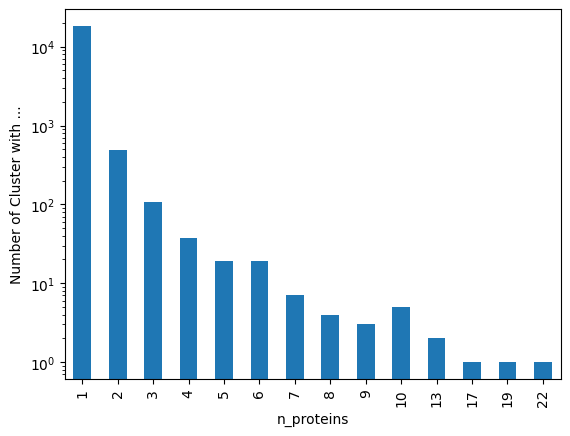

In [14]:
# # create a df with clusters as entry
# uniref_df = uniref_df.groupby('UniRef50_Cluster').agg({
#     'protein': list,
#     'gene': list,
# }).reset_index()

# # count
# uniref_df["n_proteins"] = uniref_df.protein.apply(len)
# uniref_df["n_genes"] = uniref_df.gene.apply(len)
# uniref_df.sort_values(by="n_proteins", inplace=True, ascending=False)

# # plot
# display(uniref_df)
# uniref_df.n_proteins.value_counts().sort_index().plot(kind="bar", logy=True, ylabel="Number of Cluster with ...")

In [15]:
# # CHECK: genes or proteins shared acorss clusters

# # explode the lists into one row per (cluster, protein)
# protein_cluster_map = uniref_df.explode("protein")[["UniRef50_Cluster", "protein"]].dropna()
# gene_cluster_map = uniref_df.explode("gene")[["UniRef50_Cluster", "gene"]].dropna()

# # group by protein and collect all clusters that contain it
# protein_to_clusters = protein_cluster_map.groupby("protein")["UniRef50_Cluster"].unique()
# gene_to_clusters = gene_cluster_map.groupby("gene")["UniRef50_Cluster"].unique()

# # keep only proteins that occur in >1 cluster
# shared_proteins = protein_to_clusters[protein_to_clusters.apply(len) > 1]
# shared_genes = gene_to_clusters[gene_to_clusters.apply(len) > 1]

# print(f"{len(shared_proteins)} proteins are shared between clusters")
# #display(shared_proteins.head())
# print(f"{len(shared_genes)} genes are shared between clusters")
# #display(shared_genes.head())


0 proteins are shared between clusters
0 genes are shared between clusters


<!-- ## Mark positive genes and clusters -->

cluster_label
negative    13540
positive     5447
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive
9864,UniRef50_Q6R6M4,"[Q7RTZ2, C9JJH3, C9JVI0, C9JPN9, C9JLJ4, C9J2P...","[USP17L1, USP17L10, USP17L11, USP17L12, USP17L...",19,19,positive,"[Q7RTZ2, C9JJH3, C9JVI0, C9JPN9, C9JLJ4, C9J2P...","[USP17L1, USP17L10, USP17L11, USP17L12, USP17L...",18
2882,UniRef50_P02795,"[P04731, P07438, A1L3X4, P80294, P0DM35, Q9308...","[MT1A, MT1B, MT1DP, MT1H, MT1HL1, MT1L, MT1M, ...",8,8,positive,"[P04731, P07438, A1L3X4, P80294, P0DM35, Q9308...","[MT1A, MT1B, MT1DP, MT1H, MT1HL1, MT1L, MT1M, ...",8
6512,UniRef50_Q01534,"[Q01534, P0CW01, A6NKD2, P0CV98, P0CV99, P0CW0...","[TSPY1, TSPY10, TSPY2, TSPY3, TSPY4, TSPY8, TS...",7,7,positive,"[Q01534, P0CW01, A6NKD2, P0CV98, P0CV99, P0CW0...","[TSPY1, TSPY10, TSPY2, TSPY3, TSPY4, TSPY8, TS...",7
9866,UniRef50_Q6RFH8,"[P0CJ85, P0CJ86, P0CJ87, P0CJ88, P0CJ89, P0CJ9...","[DUX4L2, DUX4L3, DUX4L4, DUX4L5, DUX4L6, DUX4L...",7,7,positive,"[P0CJ85, P0CJ86, P0CJ87, P0CJ88, P0CJ89, P0CJ9...","[DUX4L2, DUX4L3, DUX4L4, DUX4L5, DUX4L6, DUX4L...",7
2094,UniRef50_O75437,"[O75437, Q9Y2Q1, Q9P255, Q6ZN08, P0DKX0, O7537...","[ZNF254, ZNF257, ZNF492, ZNF66, ZNF728, ZNF737...",7,7,positive,"[O75437, Q9Y2Q1, Q9P255, Q6ZN08, P0DKX0, O7537...","[ZNF254, ZNF257, ZNF492, ZNF66, ZNF728, ZNF737...",7


(18987, 9)

<Axes: xlabel='n_genes_positive'>

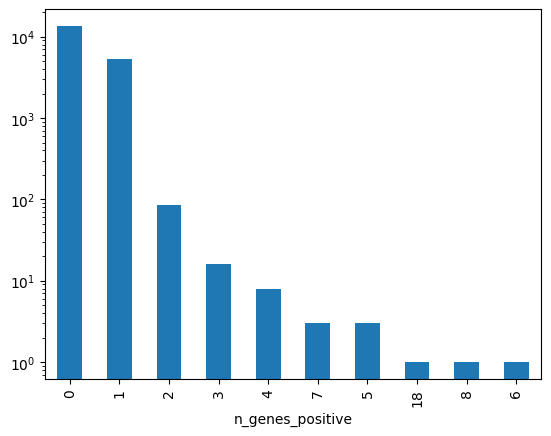

In [16]:
# # Add the 'label' column: 'positive' if at least one protein maps to a positive gene, otherwise 'negative'
# uniref_df["cluster_label"] = uniref_df["gene"].apply(
#     lambda gene_list: "positive" 
#     if any(g in positive_genes for g in gene_list)
#     else "negative"
# )

# # plot how many postive genesets
# print(uniref_df["cluster_label"].value_counts())#.sort_index().plot(kind="bar", logy=True,)

# #########

# # create list of genes AND CORREPSONDET prots that are postive (from above)

# # unzip in parallel pritens_clened and genes_clened and create ritens_clened_psotive and genes_clened_positive 
#     # maintain if proteins comes form psotive gene
# uniref_df["proteins_positive"], uniref_df["genes_positive"] = zip(*uniref_df.apply(
#     lambda row: (
#         [p for p, g in zip(row["protein"], row["gene"]) if g in positive_genes],
#         [g for g in row["gene"] if g in positive_genes]
#     ),
#     axis=1
# ))
# uniref_df["n_genes_positive"] = uniref_df["genes_positive"].apply(len)
# uniref_df.sort_values(by="n_genes_positive", ascending=False, inplace=True)

# display(uniref_df.head(5))
# display(uniref_df.shape)
# uniref_df.n_genes_positive.value_counts().plot(kind="bar", logy=True)

<!-- ## Give probs to positive genes -->

In [17]:
# # give probablities to be samped to each protein
# uniref_df["logits"] = uniref_df["genes_positive"].apply(
#     lambda gene_list: [positive_gene_freq_map.get(g, 0) for g in gene_list]
# )
# def safe_softmax(logits):
#     if len(logits) == 0:
#         return []  # return empty list if no logits
#     return softmax(logits).tolist()  # convert numpy array to list
# uniref_df["probs"] = uniref_df["logits"].apply(safe_softmax)

# uniref_df.head(2)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs
9864,UniRef50_Q6R6M4,"[Q7RTZ2, C9JJH3, C9JVI0, C9JPN9, C9JLJ4, C9J2P...","[USP17L1, USP17L10, USP17L11, USP17L12, USP17L...",19,19,positive,"[Q7RTZ2, C9JJH3, C9JVI0, C9JPN9, C9JLJ4, C9J2P...","[USP17L1, USP17L10, USP17L11, USP17L12, USP17L...",18,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.05555555555555555, 0.05555555555555555, 0.0..."
2882,UniRef50_P02795,"[P04731, P07438, A1L3X4, P80294, P0DM35, Q9308...","[MT1A, MT1B, MT1DP, MT1H, MT1HL1, MT1L, MT1M, ...",8,8,positive,"[P04731, P07438, A1L3X4, P80294, P0DM35, Q9308...","[MT1A, MT1B, MT1DP, MT1H, MT1HL1, MT1L, MT1M, ...",8,"[1, 1, 1, 1, 1, 1, 1, 1]","[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1..."


<!-- ## Create lists of NEGATIVE genes within i can sample

Negative genes are too many.

We need a subsampling before sample them for the final df.
We need to subsample in differt ways:

- lets have nice lenghts: too long, too short
- they cant be positive genes
- they cant be ambiguos genes
- many proteins of same class but still differt (ex. odoranr receptros)
    - SOLUTION: solve wht pfam and interpro domains --> group proteins that have same domains --> take only one from the group


Other ideas if necessary:
- cluster proteins using uniT5 embs and take a protien for each cluster
- proteins still 90% similairty, need to remove reduntat seqeunces?
    - --> impossible, clusters are dissimailr by 50% -->

<!-- ### *) Read Domains df -->

In [18]:
# interpro_df = pd.read_csv(config["data_paths"]["interprot_domains"], sep="\t")

# def extract_ids(cell, prefix):
#     if pd.isna(cell):
#         return []
#     # Find all matches like PFxxxxx or IPRxxxxx
#     ids = re.findall(rf"{prefix}\d+", cell)
#     return list(set(ids))  # optional: remove duplicates

# # Apply parsing
# interpro_df["Pfam_list"] = interpro_df["Pfam"].apply(lambda x: extract_ids(str(x), "PF"))
# interpro_df["InterPro_list"] = interpro_df["InterPro"].apply(lambda x: extract_ids(str(x), "IPR"))

# interpro_df["n_Pfam"] = interpro_df["Pfam_list"].apply(len)
# interpro_df["n_InterPro"] = interpro_df["InterPro_list"].apply(len)

# interpro_df["all_domains"] = interpro_df.apply(lambda row: set(row['Pfam_list']) | set(row['InterPro_list']), axis=1)

# interpro_df

,Entry,Length,Pfam,InterPro,Pfam_list,InterPro_list,n_Pfam,n_InterPro,all_domains
0,A0A087X1C5,515,PF00067; p450; 2.;,"IPR001128; Cyt_P450.;""IPR017972; Cyt_P450_CS.""...",[PF00067],"[IPR050182, IPR036396, IPR017972, IPR008069, I...",1,6,"{IPR050182, IPR036396, PF00067, IPR017972, IPR..."
1,A0A0B4J2F0,54,PF23670; PIGBOS1; 1.;,NaN,[PF23670],[],1,0,{PF23670}
2,A0A0C5B5G6,16,PF21945; MT-RNR1; 1.;,IPR054130; MT-RNR1.;,[PF21945],[IPR054130],1,1,"{IPR054130, PF21945}"
3,A0A0K2S4Q6,201,PF07686; V-set; 1.;,"IPR050671; CD300_family_receptors.;""IPR007110;...",[PF07686],"[IPR013106, IPR013783, IPR036179, IPR003599, I...",1,6,"{IPR013106, IPR003599, IPR007110, IPR013783, I..."
4,A0A0U1RRE5,68,PF21949; NoBody; 1.;,IPR047852; NoBody.;,[PF21949],[IPR047852],1,1,"{PF21949, IPR047852}"
...,...,...,...,...,...,...,...,...,...
20415,Q9UI25,63,NaN,NaN,[],[],0,0,{}
20416,Q9UI54,55,NaN,NaN,[],[],0,0,{}
20417,Q9UI72,69,NaN,NaN,[],[],0,0,{}
20418,Q9Y3F1,56,PF15789; Hyr1; 1.;,IPR031573; Cell_wall_rpt.;,[PF15789],[IPR031573],1,1,"{PF15789, IPR031573}"


<!-- ### *) Create df gene-prot to define negative prots

Attch col to say if the protsin is ok based on taht criterion -->

In [19]:
# # Create lists to store protein-gene pairs
# proteins_list = []
# genes_list = []

# # Iterate through each row and expand the lists
# for _, row in uniref_df.iterrows():
#     proteins = row['protein']
#     genes = row['gene']
    
#     # Add each protein-gene pair
#     for protein, gene in zip(proteins, genes):
#         proteins_list.append(protein)
#         genes_list.append(gene)

# # Create new dataframe with unique pairs
# putative_negative_protein_gene_df = pd.DataFrame({
#     'protein': proteins_list,
#     'gene': genes_list
# })#.drop_duplicates() # no duplicates thnaks tot he previous steps

# putative_negative_protein_gene_df = pd.merge(how="left", left=putative_negative_protein_gene_df, right=interpro_df[["Entry", "Length"]], left_on="protein", right_on="Entry").drop(columns=["Entry"])

# display(putative_negative_protein_gene_df)

,protein,gene,Length
0,Q7RTZ2,USP17L1,530
1,C9JJH3,USP17L10,530
2,C9JVI0,USP17L11,530
3,C9JPN9,USP17L12,530
4,C9JLJ4,USP17L13,530
...,...,...,...
20179,Q5VWM3,PRAMEF18,479
20180,Q5SWL8,PRAMEF19,479
20181,O60811,PRAMEF2,474
20182,A3QJZ6,PRAMEF22,481


<!-- ### Filter by Length -->

In [ ]:
putative_negative_protein_gene_df = putative_negative_protein_gene_df[
    (putative_negative_protein_gene_df.Length >= config["dataset_creation"]["min_length_negative_protein"]) &
    (putative_negative_protein_gene_df.Length <= config["dataset_creation"]["max_length_negative_protein"]) 
]
putative_negative_protein_gene_df

<!-- ### Filter by Positive/Ambiguos -->

In [21]:
# putative_negative_protein_gene_df = putative_negative_protein_gene_df[
#     (~ putative_negative_protein_gene_df.gene.isin(ambiguos_genes)) &
#     (~ putative_negative_protein_gene_df.gene.isin(positive_genes)) 
# ]
# putative_negative_protein_gene_df

,protein,gene,Length
13,Q0WX57,USP17L24,530
49,Q16385,SSX2,188
51,O60224,SSX4,188
85,Q5DJT8,CT45A2,189
88,P0DMU7,CT45A6,189
...,...,...,...
20179,Q5VWM3,PRAMEF18,479
20180,Q5SWL8,PRAMEF19,479
20181,O60811,PRAMEF2,474
20182,A3QJZ6,PRAMEF22,481


<!-- ### Remove duplicated protein domains -->

In [22]:
# # Filter to current subset of prots
# interpro_df = interpro_df[interpro_df.Entry.isin(putative_negative_protein_gene_df.protein.to_list())]

# # Convert sets to frozensets for grouping (sets aren't hashable)
# interpro_df['domains_hashable'] = interpro_df['all_domains'].apply(frozenset)

# # Group by domains and aggregate
# final_groups_df = (
#     interpro_df[interpro_df.duplicated(subset=['domains_hashable'], keep=False)] #keep=False, mark all pccurencies
#     .groupby('domains_hashable')['Entry']  # group by set of domains
#     .agg(Proteins_in_Group=list, Group_Size='size')
#         #Collect all the protein_id values in the group into a list
#         #'size'	Count how many items are in the group
#     .reset_index()
#     .sort_values('Group_Size', ascending=False)
# )

# # Convert frozensets back to sets for display
# final_groups_df['all_domains'] = final_groups_df['domains_hashable'].apply(set)
# final_groups_df = final_groups_df.drop(columns=['domains_hashable'])

# display(final_groups_df)

# # Clean up the temporary column
# interpro_df = interpro_df.drop(columns=['domains_hashable'])
# interpro_df = interpro_df.drop_duplicates(subset="all_domains")

# # Filter df
# putative_negative_protein_gene_df = putative_negative_protein_gene_df[putative_negative_protein_gene_df.protein.isin(interpro_df.Entry.to_list())]

# print("Remained proteins:", len(putative_negative_protein_gene_df))

/tmp/ipykernel_620690/2307221464.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpro_df['domains_hashable'] = interpro_df['all_domains'].apply(frozenset)


,Proteins_in_Group,Group_Size,all_domains
0,"[B0L3A2, O97980, P0DI83, P17813, P26371, P6032...",494,{}
1403,"[O43749, O95047, P34982, Q8NG98, Q8NHC4, Q96KK...",250,"{IPR000725, PF13853, IPR000276, IPR017452}"
1135,"[P01593, P01594, P01597, P01602, P01619, P0169...",65,"{IPR013106, IPR050150, IPR003599, IPR007110, I..."
781,"[Q9H255, A6NGY5, Q8NGH7, Q8NGI2, Q8NGK2, Q8NH5...",58,"{PF13853, IPR000276, IPR017452, IPR050402, IPR..."
1133,"[P01742, P01764, P01768, P01772, P01780, P0181...",57,"{IPR013106, IPR050199, IPR007110, IPR013783, I..."
...,...,...,...
18,"[Q8IWZ8, Q8IX01]",2,"{PF01805, IPR040169, IPR035967, IPR000061, PF0..."
17,"[Q8IXL7, Q9Y3D2]",2,"{IPR028427, IPR011057, PF01641, IPR002579}"
16,"[Q8IXN7, Q9ULI2]",2,"{IPR011761, IPR004666, IPR013815, IPR013651, P..."
15,"[Q8IY21, Q5H9U9]",2,"{PF23002, IPR014001, PF00270, IPR001650, IPR05..."


Remained proteins: 9047


<!-- # Optional: subsample to remove proteins with overlapping domains -->

In [ ]:
# Convert domain sets to lists
domain_lists = interpro_df['all_domains'].apply(list)

# Create binary matrix: proteins x domains
mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(domain_lists)

# Calculate Jaccard similarity
# Jaccard = intersection / union
X = binary_matrix.astype(float)
intersection = X @ X.T #intersection counts (like AND)
union = X.sum(axis=1).reshape(-1, 1) + X.sum(axis=1) - intersection #sum of each row pair minus their intersection
jaccard_matrix = intersection / union

# Convert to DataFrame
jaccard_df = pd.DataFrame(
    jaccard_matrix, 
    index=interpro_df['Entry'], 
    columns=interpro_df['Entry']
)

print(f"Shape: {binary_matrix.shape} (proteins x domains)")
print(f"\nJaccard similarity matrix:")
display(jaccard_df)

In [ ]:
# # Flatten the Jaccard matrix (exclude diagonal if it's 1.0 self-similarity)
# jaccard_values = jaccard_matrix[np.triu_indices_from(jaccard_matrix, k=1)]  # Upper triangle only
# jaccard_values = jaccard_values[jaccard_values != 0]

# # Create histogram
# plt.figure(figsize=(10, 6))
# plt.hist(jaccard_values, bins=100, edgecolor='black', alpha=0.7)
# plt.xlabel('Jaccard Similarity', fontsize=12)
# plt.ylabel('Frequency', fontsize=12)
# plt.title('Distribution of Jaccard Similarities', fontsize=14)
# plt.grid(axis='y', alpha=0.3)

# # Add statistics
# mean_val = np.mean(jaccard_values)
# median_val = np.median(jaccard_values)
# plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
# plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.3f}')
# plt.legend()

# # Print summary statistics
# print("Jaccard Similarity Statistics:")
# print(f"Min: {jaccard_values.min():.4f}")
# print(f"Max: {jaccard_values.max():.4f}")
# print(f"Mean: {mean_val:.4f}")
# print(f"Median: {median_val:.4f}")
# print(f"Std: {np.std(jaccard_values):.4f}")

In [ ]:
# # Create edge list using SIMILARITY (Jaccard) as weights
# # Leiden with ModularityVertexPartition: higher weight = stronger connection
# threshold = median_val  # Minimum Jaccard similarity to create an edge

# edges = []
# weights = []
# for i in range(len(jaccard_df)):
#     for j in range(i+1, len(jaccard_df)):
#         similarity = jaccard_matrix[i, j]
#         if similarity > threshold:  # Use similarity directly
#             edges.append((i, j))
#             weights.append(similarity)  # Higher Jaccard = stronger edge

# # Create igraph
# g = ig.Graph(n=len(jaccard_df), edges=edges)
# g.es['weight'] = weights

# # Run Leiden clustering
# partition = leidenalg.find_partition(
#     g, 
#     leidenalg.ModularityVertexPartition,
#     weights='weight',
#     n_iterations=-1,  # Run until convergence
#     seed=42 
# )

# # Add cluster labels to dataframe
# interpro_df['Leiden_Cluster'] = partition.membership

# for i, g in interpro_df.groupby(['Leiden_Cluster']):
#     print("Cluster name", i, "Lenght:", len(g))
#     display("Memebers:", g.Entry.unique())
#     if i[0] == 0:
#         break

# print(f"\nNumber of clusters: {len(set(partition.membership))}")
# print(f"Modularity: {partition.modularity:.3f}")
# print(f"\nCluster sizes:")
# display(interpro_df['Leiden_Cluster'].value_counts().sort_index())

# # Check for singletons (clusters with only 1 member)
# cluster_sizes = interpro_df['Leiden_Cluster'].value_counts()
# singletons = cluster_sizes[cluster_sizes == 1]
# print(f"\nSingletons (clusters of size 1): {len(singletons)}")

In [ ]:
# # retain onlyu one prot form each cluster
# interpro_df_filtered = interpro_df.drop_duplicates(subset=["Leiden_Cluster"]).copy()
# display(interpro_df_filtered)

# # Filter df
# putative_negative_protein_gene_df = putative_negative_protein_gene_df[putative_negative_protein_gene_df.protein.isin(interpro_df_filtered.Entry.to_list())]
# display(putative_negative_protein_gene_df)


<!-- ### Prepare col where to sample negatives -->

In [ ]:
# Create list of putative negative genes/protein        
    # ATTENTION; putatove = neither postive neither ambigous
uniref_df["putative_negative_proteins"], uniref_df["putative_negative_genes"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if p in putative_negative_protein_gene_df.protein.to_list()],
        [g for p, g in zip(row["protein"], row["gene"]) if p in putative_negative_protein_gene_df.protein.to_list()],
    ),
    axis=1
))
# count
uniref_df["n_putative_negative_genes"] = uniref_df.putative_negative_genes.apply(len)

# ATTENTION: same NEGATIVE clusters coudl have 0 proteins
# necause all proteins are postive OR ambigous so nothing left to sample as negative)

display(uniref_df.head(5))


<!-- # *) Are there enriched clusters? -->

fraction_positive
0.000000    18084
0.333333        1
0.400000        1
0.500000        7
0.666667        1
0.800000        1
1.000000      892
Name: count, dtype: int64


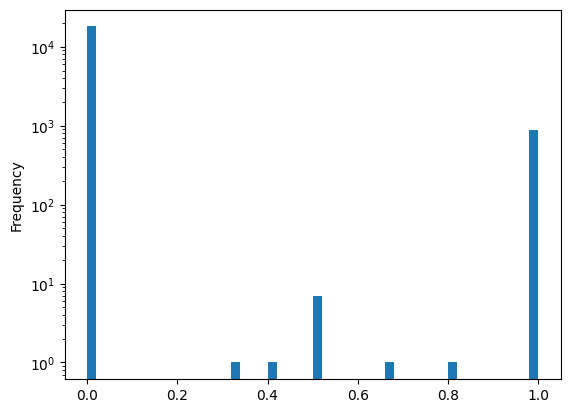

In [ ]:
# FRACTION OF CLUSTER OCCUPIED BY POSITIVE GENES
uniref_df["fraction_positive"] = uniref_df.n_genes_positive / uniref_df.n_genes
uniref_df.sort_values(by="fraction_positive", inplace=True, ascending=False)

# hsit
uniref_df.fraction_positive.plot(kind="hist", logy=True, bins=50)
print(uniref_df.fraction_positive.value_counts().sort_index())


In [ ]:
# # HYPERGEMOETRIC TEST

# # Filter genesets with enough genes
#     # ATTENTION
#     # CANNOT USE TOO SMALL DRAWING (n) --> test power comes from the changing probabilities over several draws, known as sampling without replacemen
# uniref_df_big = uniref_df[uniref_df.n_genes >= 1].copy()

# # Define background
# total_genes = len(set().union(*uniref_df_big["gene"]))
# total_positive = len(set().union(*uniref_df_big["genes_positive"]))
# print(f"Unique total genes: {total_genes}")
# print(f"Unique total positive genes: {total_positive}")

# # Run enrichment test
# results = uniref_df_big.apply(
#     lambda row: pd.Series(
#         dataf.per_cluster_hypergeom_test(
#             row["n_genes"], 
#             row["n_genes_positive"], 
#             total_genes, 
#             total_positive
#         )
#     ), 
#     axis=1
# )
# results.columns = ["enrichment_prob", "enrichment_pvalue"]

# # Combine results
# df_uniref_enriched = pd.concat([uniref_df_big, results], axis=1)
# df_uniref_enriched = df_uniref_enriched.sort_values("enrichment_pvalue")

# # Multiple testing correction (FDR)
# df_uniref_enriched["enrichment_pvalue_adj"] = multipletests(
#     df_uniref_enriched["enrichment_pvalue"], 
#     method="fdr_bh"
# )[1]
# df_uniref_enriched["significant"] = df_uniref_enriched["enrichment_pvalue_adj"] < 0.05

# # Summary
# print(f"\nSignificant enriched gene sets: {df_uniref_enriched['significant'].sum()} / {len(df_uniref_enriched)}")
# display(
#     df_uniref_enriched[
#         ["UniRef50_Cluster", "n_genes", "n_genes_positive", 
#          "enrichment_prob", "enrichment_pvalue", 
#          "enrichment_pvalue_adj", "significant"]
#     ].head(10)
# )

# # only enriched
# df_uniref_significant = df_uniref_enriched[df_uniref_enriched['significant'] == True]

Unique total genes: 20184
Unique total positive genes: 969

Significant enriched gene sets: 3 / 18987


,UniRef50_Cluster,n_genes,n_genes_positive,enrichment_prob,enrichment_pvalue,enrichment_pvalue_adj,significant
2772,UniRef50_P01563,10,10,6.221557e-14,6.217249e-14,1.180469e-09,True
3438,UniRef50_P0DN86,5,5,2.525277e-07,2.525277e-07,2.397372e-03,True
3501,UniRef50_P10147,4,4,5.280839e-06,5.280839e-06,3.342243e-02,True
2964,UniRef50_P04746,5,4,2.514155e-05,2.539408e-05,1.205394e-01,False
3596,UniRef50_P11464,3,3,1.103236e-04,1.103236e-04,2.094714e-01,False
11228,UniRef50_Q8IU54,3,3,1.103236e-04,1.103236e-04,2.094714e-01,False
7024,UniRef50_Q13072,3,3,1.103236e-04,1.103236e-04,2.094714e-01,False
3490,UniRef50_P0DY26,3,3,1.103236e-04,1.103236e-04,2.094714e-01,False
2756,UniRef50_P01241,3,3,1.103236e-04,1.103236e-04,2.094714e-01,False
2732,UniRef50_P01036,3,3,1.103236e-04,1.103236e-04,2.094714e-01,False


<!-- # Create Dataset -->

<!-- ## Positive class sampling -->

In [ ]:
# # Filter only positive clusters
# uniref_df_pos = uniref_df[uniref_df.cluster_label == "positive"].copy()

# # sample or take all postive proteins?
# if not config["dataset_creation"]["sample_positive_genes"]:
#     SAMPLE_N_POSITIVE = uniref_df_pos.n_genes_positive.max() # the number to sample is the max possbile
# else:
#     SAMPLE_N_POSITIVE = config["dataset_creation"]["number_positive_genes_to_sample_per_cluster"]

# uniref_df_pos["proteins_sampled"], uniref_df_pos["genes_sampled"] = zip(
#     *uniref_df_pos.apply(
#             dataf.sample_sampled_from_single_row, 
#             axis=1, 
#             min_sample_n=SAMPLE_N_POSITIVE, 
#             gene_col="genes_positive",  # ATTENTION_: sample from correct columns
#             prot_col="proteins_positive", 
#             probs_col="probs")
# )
# uniref_df_pos["n_proteins_sampled"] = uniref_df_pos.proteins_sampled.apply(len)

# display(uniref_df_pos.head(2))
# print(uniref_df_pos.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled
10065,UniRef50_Q6XE38,[Q6XE38],[SCGB1D4],1,1,positive,[Q6XE38],[SCGB1D4],1,[1],[1.0],[],[],0,1.0,[Q6XE38],[SCGB1D4],1
17374,UniRef50_Q9NZK5,[Q9NZK5],[ADA2],1,1,positive,[Q9NZK5],[ADA2],1,[1],[1.0],[],[],0,1.0,[Q9NZK5],[ADA2],1


(903, 18)


<!-- ## Negative Sampling

ATTENTION: cannto have portisn from the same cluster split in class psotive and negative -->

In [ ]:
# # Filter only positive clusters
#     # sample from clusters that do nto contain psotive (negative label of before)
# uniref_df_neg = uniref_df[
#     (uniref_df.n_putative_negative_genes > 0) & # some lcuster maybe haev only ambigus genes
#     (uniref_df.cluster_label == "negative") # avoid proteins from proteins class are used as eagtive
#     ].copy() 

# uniref_df_neg["proteins_sampled"], uniref_df_neg["genes_sampled"] = zip(
#     *uniref_df_neg.apply(
#             dataf.sample_sampled_from_single_row, 
#             axis=1, 
#             min_sample_n=SAMPLE_N_POSITIVE, 
#             gene_col="putative_negative_genes", 
#             prot_col="putative_negative_proteins", 
#             probs_col=None # uniform
#             )
# )
# uniref_df_neg["n_proteins_sampled"] = uniref_df_neg.proteins_sampled.apply(len)

# # ATTENTION: same clusters coudl have 0 proteins to sample from (all proteins are postive OR ambigous so nothing left to sample as negative)
# uniref_df_neg = uniref_df_neg[uniref_df_neg.n_proteins_sampled > 0]

# display(uniref_df_neg.head())
# print(uniref_df_neg.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled
4933,UniRef50_P39023,"[P39023, Q92901]","[RPL3, RPL3L]",2,2,negative,[],[],0,[],[],[P39023],[RPL3],1,0.0,[P39023],[RPL3],1
162,UniRef50_A0A1B0GTR3,"[A0A1B0GTR3, P0DPH9]","[CXorf51A, CXorf51B]",2,2,negative,[],[],0,[],[],[P0DPH9],[CXorf51B],1,0.0,[P0DPH9],[CXorf51B],1
3644,UniRef50_P12277,"[P12277, P06732]","[CKB, CKM]",2,2,negative,[],[],0,[],[],[P06732],[CKM],1,0.0,[P06732],[CKM],1
2463,UniRef50_O95298,"[O95298, E9PQ53]","[NDUFC2, NDUFC2-KCTD14]",2,2,negative,[],[],0,[],[],[O95298],[NDUFC2],1,0.0,[O95298],[NDUFC2],1
4153,UniRef50_P21217,"[P21217, Q11128]","[FUT3, FUT5]",2,2,negative,[],[],0,[],[],[P21217],[FUT3],1,0.0,[P21217],[FUT3],1


(2556, 18)


<!-- ## Make dataset

- concat pos and neg
- expand to have

| Cluster | protein name | label | seq | -->

In [ ]:
# # add labels
# uniref_df_pos["label_single_prot"] = 1
# uniref_df_neg["label_single_prot"] = 0

# # merge --> each entry is a cluster
# dataset_df = pd.concat([uniref_df_pos, uniref_df_neg])
# display(dataset_df.head())
# display(dataset_df.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled,label_single_prot
10065,UniRef50_Q6XE38,[Q6XE38],[SCGB1D4],1,1,positive,[Q6XE38],[SCGB1D4],1,[1],[1.0],[],[],0,1.0,[Q6XE38],[SCGB1D4],1,1
17374,UniRef50_Q9NZK5,[Q9NZK5],[ADA2],1,1,positive,[Q9NZK5],[ADA2],1,[1],[1.0],[],[],0,1.0,[Q9NZK5],[ADA2],1,1
580,UniRef50_A6NIE9,[A6NIE9],[PRSS29P],1,1,positive,[A6NIE9],[PRSS29P],1,[1],[1.0],[],[],0,1.0,[A6NIE9],[PRSS29P],1,1
3216,UniRef50_P08833,[P08833],[IGFBP1],1,1,positive,[P08833],[IGFBP1],1,[1],[1.0],[],[],0,1.0,[P08833],[IGFBP1],1,1
18069,UniRef50_Q9UKZ9,[Q9UKZ9],[PCOLCE2],1,1,positive,[Q9UKZ9],[PCOLCE2],1,[1],[1.0],[],[],0,1.0,[Q9UKZ9],[PCOLCE2],1,1


(3459, 19)

In [ ]:
# # Create long df

# # smaller df
# cols_to_keep = ['UniRef50_Cluster', 'proteins_sampled',
#                 'genes_sampled', 'label_single_prot']
# dataset_df_small = dataset_df[cols_to_keep].copy()
# display(dataset_df_small)

# # Create a new DataFrame where each row corresponds to a (protein, gene) pair
# rows = []
# for _, row in dataset_df_small.iterrows():
#     cluster = row["UniRef50_Cluster"]
#     label = row["label_single_prot"]
#     proteins = row["proteins_sampled"]
#     genes = row["genes_sampled"]

#     # zip ensures 1-to-1 pairing between proteins and genes
#     for prot, gene in zip(proteins, genes):
#         rows.append({
#             "UniRef50_Cluster": cluster,
#             "protein": prot,
#             "gene": gene,
#             "label": label
#         })

# df_long = pd.DataFrame(rows)

# print("ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins")
# print(df_long.protein.nunique(), "/ ~20000")

# # checj fro duplcates
# print("\nDuplicated rows/proteins: ", df_long.shape[0] - df_long.protein.nunique())

# df_long

,UniRef50_Cluster,proteins_sampled,genes_sampled,label_single_prot
10065,UniRef50_Q6XE38,[Q6XE38],[SCGB1D4],1
17374,UniRef50_Q9NZK5,[Q9NZK5],[ADA2],1
580,UniRef50_A6NIE9,[A6NIE9],[PRSS29P],1
3216,UniRef50_P08833,[P08833],[IGFBP1],1
18069,UniRef50_Q9UKZ9,[Q9UKZ9],[PCOLCE2],1
...,...,...,...,...
6944,UniRef50_Q12815,[Q12815],[TROAP],0
6121,UniRef50_P62081,[P62081],[RPS7],0
6738,UniRef50_Q06645,[P05496],[ATP5MC1],0
6764,UniRef50_Q07523,[Q9NYQ3],[HAO2],0


ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins
3525 / ~20000

Duplicated rows/proteins:  0


,UniRef50_Cluster,protein,gene,label
0,UniRef50_Q6XE38,Q6XE38,SCGB1D4,1
1,UniRef50_Q9NZK5,Q9NZK5,ADA2,1
2,UniRef50_A6NIE9,A6NIE9,PRSS29P,1
3,UniRef50_P08833,P08833,IGFBP1,1
4,UniRef50_Q9UKZ9,Q9UKZ9,PCOLCE2,1
...,...,...,...,...
3520,UniRef50_Q12815,Q12815,TROAP,0
3521,UniRef50_P62081,P62081,RPS7,0
3522,UniRef50_Q06645,P05496,ATP5MC1,0
3523,UniRef50_Q07523,Q9NYQ3,HAO2,0


<!-- ## Assure 1:N ratio in postive:negative class
After previos sampling sampling you will have
- | pos prot | << | neg prot | → more thna 1:3 ration
- Need to subsampled negative class
- Subsample negative class
    - Subsample the remaining cluster to have a final ratio 1:3 -->

In [ ]:
# # list of smpled positve proteins
# positive_proteins_tmp = set(df_long[df_long.label == 1]["protein"].unique())

# # list of prtein in MIXED cluster (wiht inside btoh postive and negative prteins)
#     # ATTENTUON: check no ptortien in mixed clusters
# proteins_in_mixed_clusters = df_long.groupby('UniRef50_Cluster').filter(lambda x: x['label'].nunique() > 1).sort_values(by="UniRef50_Cluster")
# print("priteins in mixed clusters:", len(proteins_in_mixed_clusters))
# proteins_in_mixed_clusters = set(proteins_in_mixed_clusters["protein"].unique())

# # proteins to NOT remove
# proteins_not_to_remove = proteins_in_mixed_clusters.union(positive_proteins_tmp)

# # give col
# df_long["can_be_removed"] = ~df_long["protein"].isin(proteins_not_to_remove)

# df_long

priteins in mixed clusters: 0


,UniRef50_Cluster,protein,gene,label,can_be_removed
0,UniRef50_Q6XE38,Q6XE38,SCGB1D4,1,False
1,UniRef50_Q9NZK5,Q9NZK5,ADA2,1,False
2,UniRef50_A6NIE9,A6NIE9,PRSS29P,1,False
3,UniRef50_P08833,P08833,IGFBP1,1,False
4,UniRef50_Q9UKZ9,Q9UKZ9,PCOLCE2,1,False
...,...,...,...,...,...
3520,UniRef50_Q12815,Q12815,TROAP,0,True
3521,UniRef50_P62081,P62081,RPS7,0,True
3522,UniRef50_Q06645,P05496,ATP5MC1,0,True
3523,UniRef50_Q07523,Q9NYQ3,HAO2,0,True


In [ ]:
# # decide fraction to susample

# # Number of positive proteins
# n_positive = df_long[df_long["label"] == 1].shape[0]
# # Number desidered negative
# n_desired_negatives = n_positive * config["dataset_creation"]["mult_factor_negative_class"]
# # Removable (negative) proteins
# removable_negatives = df_long[(df_long["label"] == 0) & (df_long["can_be_removed"])]
# # Determine fraction to subsample
# frac_to_sample = n_desired_negatives / len(removable_negatives)
# frac_to_sample = min(frac_to_sample, 1.0)  # cannot sample more than available

# frac_to_sample

1.0

In [ ]:
# # susample
# removable = df_long[df_long["can_be_removed"]]
# keep = df_long[~df_long["can_be_removed"]]

# subsampled_removable = removable.sample(frac=frac_to_sample)

# df_subsampled = pd.concat([keep, subsampled_removable]).reset_index(drop=True) # Combine back with the protected proteins

# print(df_subsampled.label.value_counts())
# df_subsampled

label
0    2556
1     969
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,label,can_be_removed
0,UniRef50_Q6XE38,Q6XE38,SCGB1D4,1,False
1,UniRef50_Q9NZK5,Q9NZK5,ADA2,1,False
2,UniRef50_A6NIE9,A6NIE9,PRSS29P,1,False
3,UniRef50_P08833,P08833,IGFBP1,1,False
4,UniRef50_Q9UKZ9,Q9UKZ9,PCOLCE2,1,False
...,...,...,...,...,...
3520,UniRef50_O75570,O75570,MTRF1,0,True
3521,UniRef50_Q6UYE1,Q6UYE1,DLEU7,0,True
3522,UniRef50_P23511,P23511,NFYA,0,True
3523,UniRef50_Q9H246,Q9H246,C1orf21,0,True


<!-- ## Give Sequence -->


In [35]:
# ### create df to join
# join_df_tmp = proteome_uniprot[["Entry", "Sequence"]].copy().rename(columns={"Sequence": "sequence"})

# # join
#     # ATTNETION: we shoudl NOT lose any col
# long_df_seq = pd.merge(how="inner", left=df_subsampled, right=join_df_tmp, left_on="protein", right_on="Entry")

# # drp cols
# long_df_seq.drop(columns=["Entry"], inplace=True)

# long_df_seq

,UniRef50_Cluster,protein,gene,label,can_be_removed,sequence
0,UniRef50_Q6XE38,Q6XE38,SCGB1D4,1,False,MRLSVCLLMVSLALCCYQAHALVCPAVASEITVFLFLSDAAVNLQV...
1,UniRef50_Q9NZK5,Q9NZK5,ADA2,1,False,MLVDGPSERPALCFLLLAVAMSFFGSALSIDETRAHLLLKEKMMRL...
2,UniRef50_A6NIE9,A6NIE9,PRSS29P,1,False,MPTTPDPGSEPPARTPRPPPLTPGLSPQPALHALSPQLLLLLFLAV...
3,UniRef50_P08833,P08833,IGFBP1,1,False,MSEVPVARVWLVLLLLTVQVGVTAGAPWQCAPCSAEKLALCPPVSA...
4,UniRef50_Q9UKZ9,Q9UKZ9,PCOLCE2,1,False,MRGANAWAPLCLLLAAATQLSRQQSPERPVFTCGGILTGESGFIGS...
...,...,...,...,...,...,...
3520,UniRef50_O75570,O75570,MTRF1,0,True,MNRHLCVWLFRHPSLNGYLQCHIQLHSHQFRQIHLDTRLQVFRQNR...
3521,UniRef50_Q6UYE1,Q6UYE1,DLEU7,0,True,MASPAPLVASISHQMVALQTLQLLQQEWGWGDGPVAPGNPRDPDHV...
3522,UniRef50_P23511,P23511,NFYA,0,True,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...
3523,UniRef50_Q9H246,Q9H246,C1orf21,0,True,MGCASAKHVATVQNEEEAQKGKNYQNGDVFGDEYRIKPVEEVKYMK...


<!-- ## Stratify dataset

We can stratify based on many metrics:
1. labels
2. PREVALENT metric
3. **based on cluster**
    - Put proteins coming from same cluster in different sets or not -->

In [ ]:
# from sklearn.model_selection import train_test_split
# import pandas as pd

# # --- group-level stratified split ---

# # pslit by cluster and then ive back set-label to each row

# # One representative row per UniRef50_Cluster
# cluster_df = long_df_seq.groupby('UniRef50_Cluster').first().reset_index()

# # Stratified split by label, but at the cluster level
#     # ists of unique cluster IDs.
# train_clusters, temp_clusters = train_test_split(
#     cluster_df['UniRef50_Cluster'],
#     test_size=0.2,
#     stratify=cluster_df['label'],
#     random_state=42
# )

# # Split the temporary set equally into validation and test
# temp_labels = cluster_df.loc[cluster_df['UniRef50_Cluster'].isin(temp_clusters), 'label']
# val_clusters, test_clusters = train_test_split(
#     temp_clusters,
#     test_size=0.5,
#     stratify=temp_labels,
#     random_state=42
# )

# # --- assign back to the full dataframe ---
# #Every row in long_df_seq inherits its set label based on its UniRef50_Cluster
# long_df_seq['set'] = ''
# long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(train_clusters), 'set'] = 'train'
# long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(test_clusters), 'set'] = 'test'

# # ATTENTION: ingore val
# long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(val_clusters), 'set'] = 'val'
# long_df_seq.loc[long_df_seq['set'] == "val", 'set'] = 'test'
# long_df_seq.loc[long_df_seq.loc[long_df_seq['set'] == 'test'].index[0], 'set'] = 'val' 

# # Check split distribution
# print(long_df_seq.groupby('set')['label'].value_counts().unstack(fill_value=0))
# display(long_df_seq)


label     0    1
set             
test    511  190
train  2045  778
val       0    1


,UniRef50_Cluster,protein,gene,label,can_be_removed,sequence,set
0,UniRef50_Q6XE38,Q6XE38,SCGB1D4,1,False,MRLSVCLLMVSLALCCYQAHALVCPAVASEITVFLFLSDAAVNLQV...,val
1,UniRef50_Q9NZK5,Q9NZK5,ADA2,1,False,MLVDGPSERPALCFLLLAVAMSFFGSALSIDETRAHLLLKEKMMRL...,train
2,UniRef50_A6NIE9,A6NIE9,PRSS29P,1,False,MPTTPDPGSEPPARTPRPPPLTPGLSPQPALHALSPQLLLLLFLAV...,train
3,UniRef50_P08833,P08833,IGFBP1,1,False,MSEVPVARVWLVLLLLTVQVGVTAGAPWQCAPCSAEKLALCPPVSA...,train
4,UniRef50_Q9UKZ9,Q9UKZ9,PCOLCE2,1,False,MRGANAWAPLCLLLAAATQLSRQQSPERPVFTCGGILTGESGFIGS...,test
...,...,...,...,...,...,...,...
3520,UniRef50_O75570,O75570,MTRF1,0,True,MNRHLCVWLFRHPSLNGYLQCHIQLHSHQFRQIHLDTRLQVFRQNR...,test
3521,UniRef50_Q6UYE1,Q6UYE1,DLEU7,0,True,MASPAPLVASISHQMVALQTLQLLQQEWGWGDGPVAPGNPRDPDHV...,train
3522,UniRef50_P23511,P23511,NFYA,0,True,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASASG...,test
3523,UniRef50_Q9H246,Q9H246,C1orf21,0,True,MGCASAKHVATVQNEEEAQKGKNYQNGDVFGDEYRIKPVEEVKYMK...,train


<!-- # Save -->

In [ ]:
# long_df_seq.to_csv(config["data_paths"]["final_dataset"], index=False)
# config["data_paths"]["final_dataset"]
# #long_df_seq.to_csv("/home/gdallagl/myworkdir/ESMSec/data/secreted/lyso_02_dataset.csv", index=False)

'/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/datasets/cc_03_dataset_final.csv'